In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram

import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [2]:
def initialize_s(qc, num_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(num_qubit - 1)
    qc.h(num_qubit - 1)
    
    for q in range(num_matching):
        qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
        
    
    return qc

In [3]:
def violate_state():
    qc = QuantumCircuit(10)
    qc.ccx(0, 1, 6)
    qc.ccx(2, 3, 7)
    qc.ccx(4, 5, 8)
    qc.x([6, 7, 8])
    qc.append(C3XGate(), [6, 7, 8, 9])
    qc.x([6, 7, 8])
    qc.ccx(4, 5, 8)
    qc.ccx(2, 3, 7)
    qc.ccx(0, 1, 6)
    oracle_violate = qc.to_gate()
    oracle_violate.name = "violate"
    #qc.draw()
    return oracle_violate

In [4]:
def compare_node1_node2():
    qc = QuantumCircuit(11)
    qc.cx(0, 2)
    qc.cx(1, 3)
    qc.cx(2, 6)
    qc.cx(3, 7)
    qc.x([6, 7])
    qc.ccx(6, 7, 10)
    qc.x([6, 7])
    qc.cx(3, 7)
    qc.cx(2, 6)
    qc.cx(1, 3)
    qc.cx(0, 2)
    oracle_edge12 = qc.to_gate()
    oracle_edge12.name = "edge12"
    #qc.draw()
    return oracle_edge12

In [5]:
def compare_node1_node3():
    qc = QuantumCircuit(12)
    qc.cx(0, 4)
    qc.cx(1, 5)
    qc.cx(4, 6)
    qc.cx(5, 7)
    qc.x([6, 7])
    qc.ccx(6, 7, 11)
    qc.x([6, 7])
    qc.cx(5, 7)
    qc.cx(4, 6)
    qc.cx(1, 5)
    qc.cx(0, 4)
    oracle_edge13 = qc.to_gate()
    oracle_edge13.name = "edge13"
    #qc.draw()
    return oracle_edge13

In [6]:
def compare_node2_node3():
    qc = QuantumCircuit(13)
    qc.cx(2, 4)
    qc.cx(3, 5)
    qc.cx(4, 6)
    qc.cx(5, 7)
    qc.x([6, 7])
    qc.ccx(6, 7, 12)
    qc.x([6, 7])
    qc.cx(5, 7)
    qc.cx(4, 6)
    qc.cx(3, 5)
    qc.cx(2, 4)
    oracle_edge23 = qc.to_gate()
    oracle_edge23.name = "edge23"
    #qc.draw()
    return oracle_edge23

In [7]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

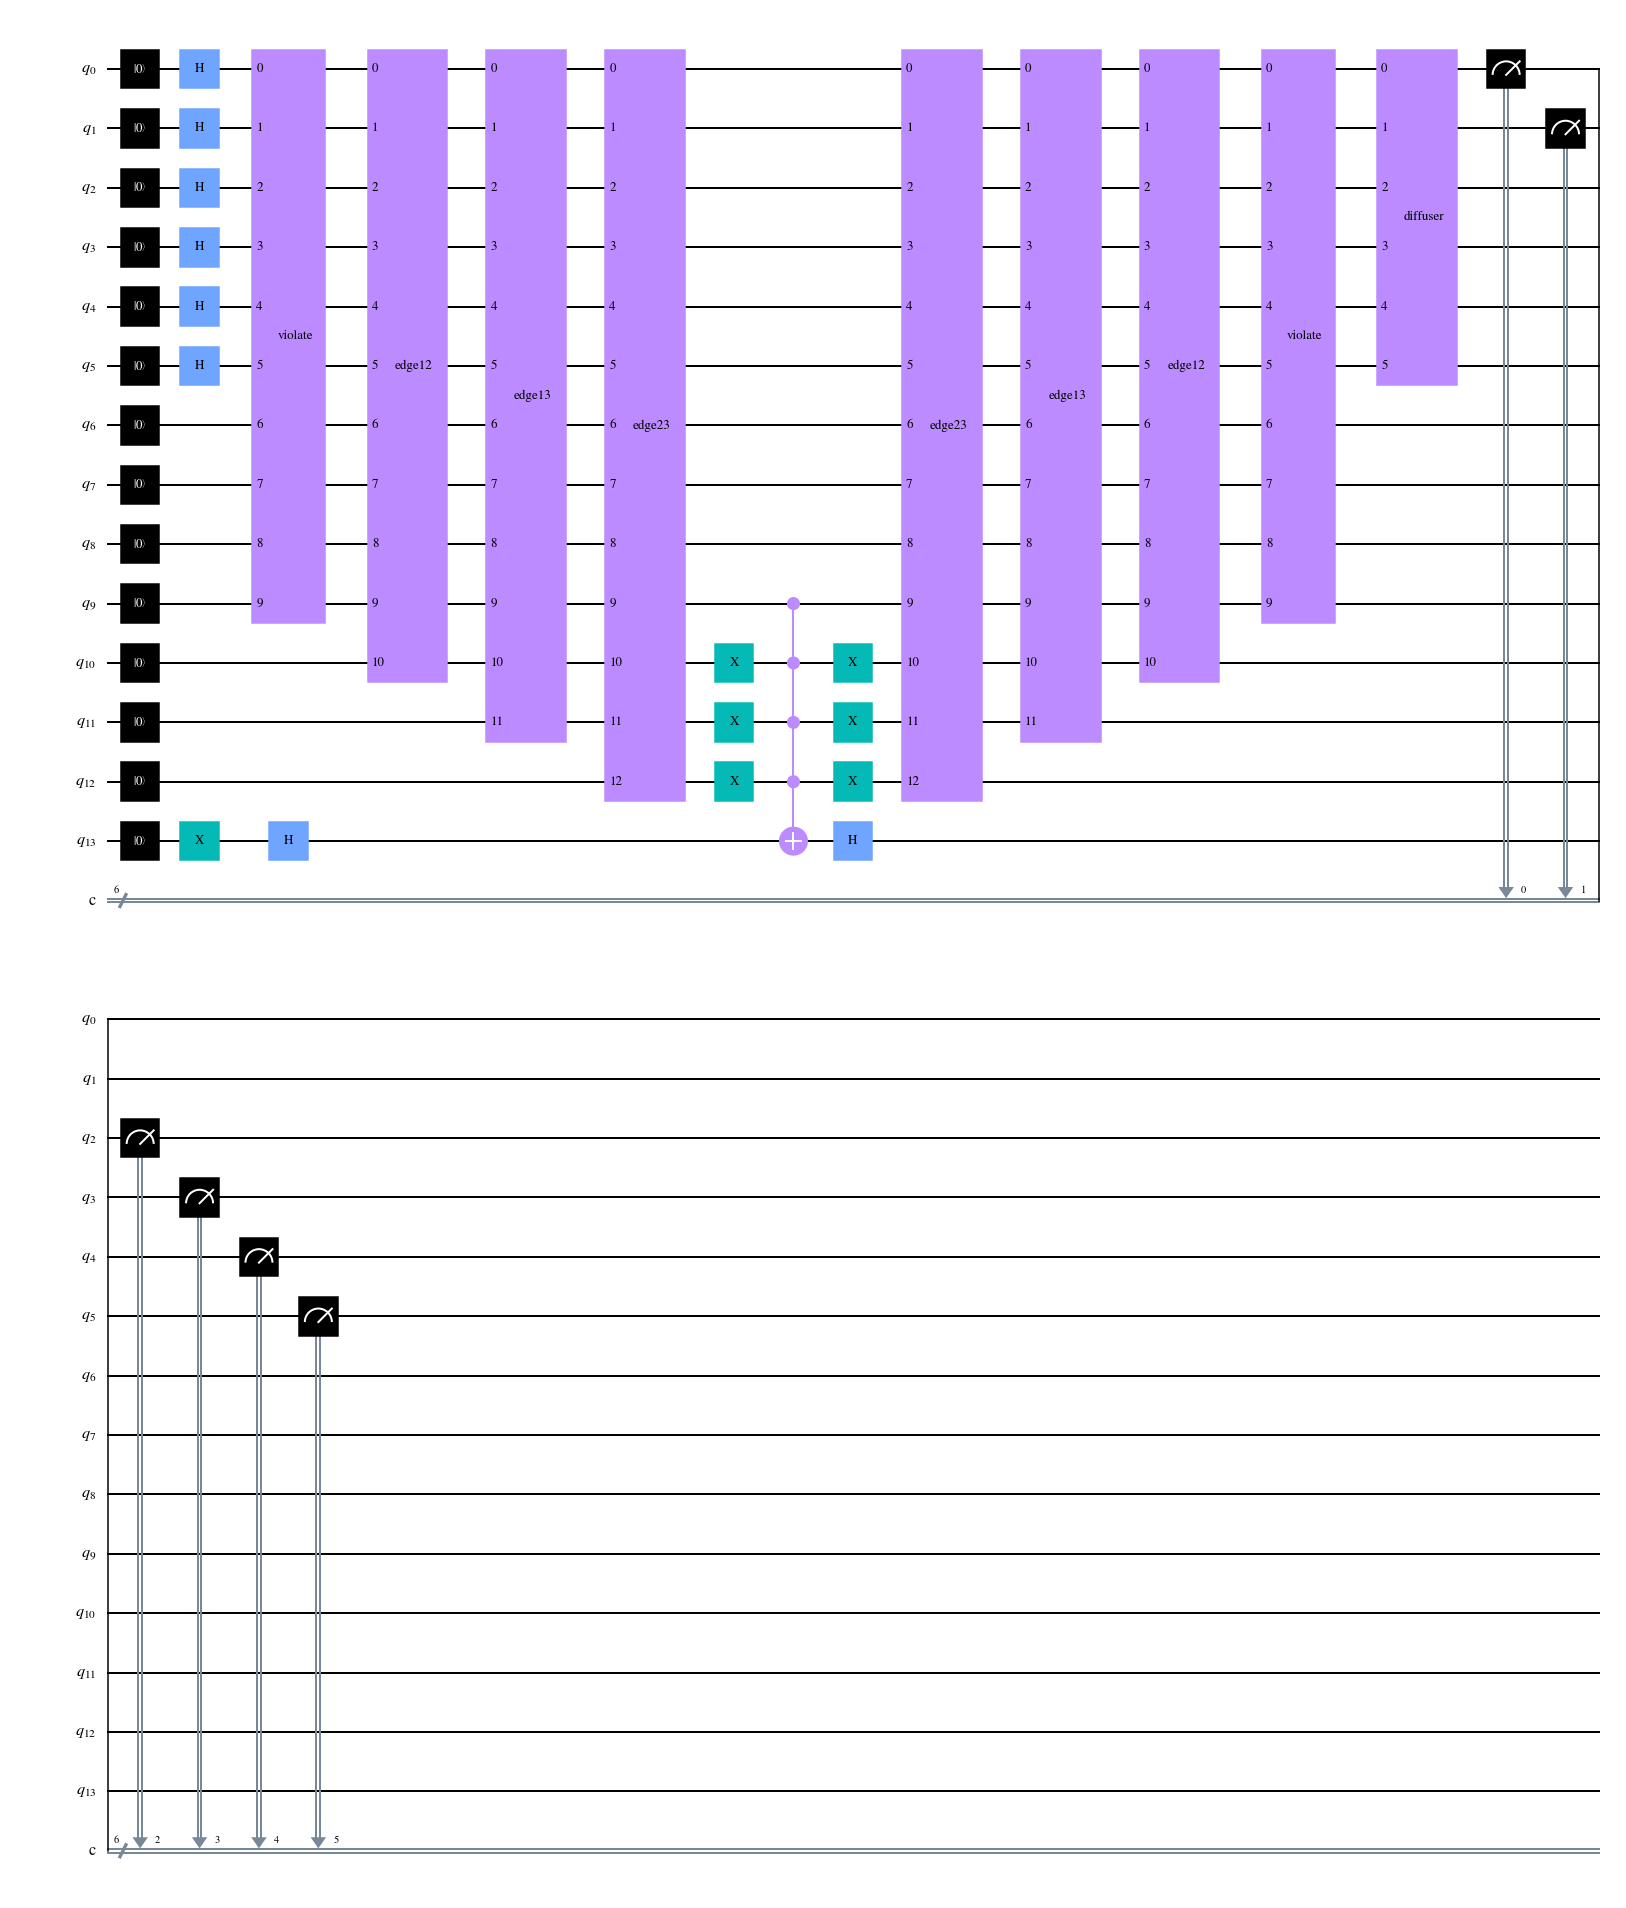

In [8]:
n_qubit = 14
n_matching = 6
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, 14))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
for i in range(1):
    #grover_circuit = violate_state(grover_circuit)
    grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit.x([10, 11, 12])
    grover_circuit.mcx([9, 10, 11, 12], 13)
    grover_circuit.x([10, 11, 12])
    grover_circuit.h([13])
    grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    grover_circuit.append(diffuser(6), [0, 1, 2, 3, 4, 5])
    
grover_circuit.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
grover_circuit.draw(output = "mpl")

In [9]:
from qiskit import BasicAer, Aer,execute
sim = Aer.get_backend('aer_simulator')

In [10]:
job = execute(grover_circuit, backend = sim, shots = 8192)

In [11]:
counts = job.result().get_counts()

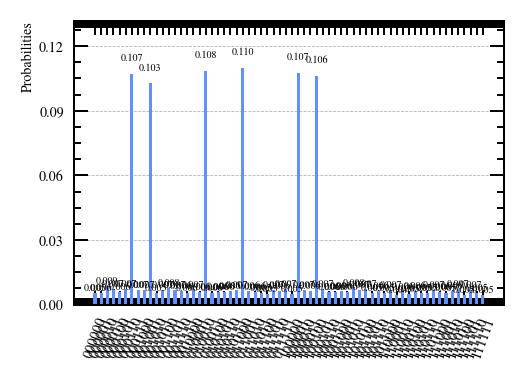

In [12]:
plot_histogram(counts)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

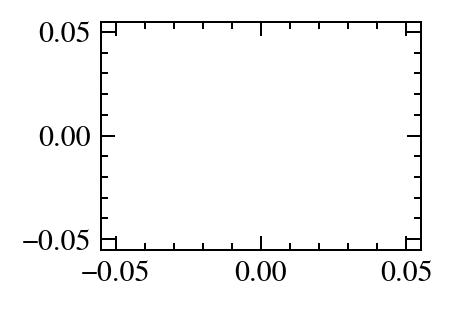

In [13]:
#이미지의 이름을 label= '(이름)'으로 사용. Latex식 수식 지원.
plt.plot([], [], ' ', label='$Matching Simulated QSA')

#np.histrogram(히스토그램을 그릴 데이터, bin 사이즈)
#np.linspace(시작지점, 끝지점, n등분)
h, bins = np.histogram(counts)
#h, bins는 고정, label은 plot의 이름
mplhep.histplot(h, bins)

#x,y축 이름 지정
plt.xlabel('Momentum [MeV]')
plt.ylabel('Events')

#y축 log scale. 비활성화는 밑줄을 지우면 됨
plt.yscale('log')

#x축 범위. y축도 동일하게 plt.ylim으로 지정가능
plt.xlim(0,10)
plt.legend()

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/home/seokju/Documents/KNU/Plots/220530/Sr_DisplacementCut.pdf')

#이미지 저장을 비활성화할시 plt.show()를 사용해야함
plt.show()

In [78]:
IBMQ.save_account('e98108019189dbd357958aedc14339c82ad0b0e12ec45536f7b7604eb16e2ff549e5041663ac8cffac7a0e0a8843588f4b839d6bad9851ca44c04aa29b273ba0', overwrite=True)

In [79]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-06-28 21:34:10,346: Credentials are already in use. The existing account in the session will be replaced.


In [80]:
provider = IBMQ.get_provider(hub='ibm-q-skku', group='korea-university', project='ku-students')

#backends = provider.backends()

In [81]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibm

In [82]:
device = provider.backends()[5]

In [83]:
device

<IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>

In [84]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=1)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [85]:
# Get the results from the computation
results = job.result()


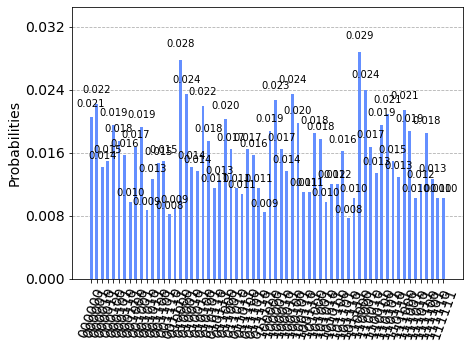

In [86]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [24]:

answer = results.get_counts(grover_circuit)


In [71]:
answer

{'000000': 37,
 '000001': 58,
 '010000': 48,
 '010001': 53,
 '010010': 62,
 '010011': 56,
 '010100': 50,
 '010101': 47,
 '010110': 41,
 '010111': 36,
 '011000': 92,
 '011001': 137,
 '011010': 102,
 '011011': 81,
 '011100': 73,
 '011101': 70,
 '011110': 64,
 '011111': 76,
 '000010': 48,
 '100000': 71,
 '100001': 48,
 '100010': 56,
 '100011': 38,
 '100100': 40,
 '100101': 28,
 '100110': 28,
 '100111': 25,
 '101000': 85,
 '101001': 75,
 '101010': 85,
 '101011': 86,
 '101100': 57,
 '101101': 62,
 '101110': 53,
 '101111': 54,
 '000011': 51,
 '110000': 62,
 '110001': 64,
 '110010': 57,
 '110011': 50,
 '110100': 66,
 '110101': 44,
 '110110': 37,
 '110111': 36,
 '111000': 91,
 '111001': 113,
 '111010': 102,
 '111011': 87,
 '111100': 76,
 '111101': 83,
 '111110': 65,
 '111111': 77,
 '000100': 34,
 '000101': 44,
 '000110': 36,
 '000111': 45,
 '001000': 90,
 '001001': 83,
 '001010': 82,
 '001011': 83,
 '001100': 61,
 '001101': 50,
 '001110': 58,
 '001111': 51}